# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [44]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1
# %pip install numpy==1.23.5

In [59]:
# Import essential libraries
import pandas as pd
import zipfile
import seaborn
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import sklearn
import keras
import os
from PIL import Image
import numpy as np
from collections import defaultdict
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

In [46]:

zip_path = 'data.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()


In [47]:
os.listdir('data')

['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']

Load the dataset.

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [48]:
# Create a function to load the raw images


def load_images(root_dir):
    images = []
    arrays = []
    labels = []

    for category in os.listdir(root_dir):
        cat_path = os.path.join(root_dir, category)
        if not os.path.isdir(cat_path):
            continue
        
        for fname in os.listdir(cat_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                path = os.path.join(cat_path, fname)
                with Image.open(path) as img:
                    images.append((category, fname, img))
                    arrays.append(np.array(img))
                    labels.append(category)

    return images,arrays, labels


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [49]:
# Get the images and their labels

root = 'data'  
imgs, img_arr, lbls = load_images(root)
print(f"Total images loaded: {len(img_arr)}")
print(f"Unique categories: {set(lbls)}")

Total images loaded: 7625
Unique categories: {'Metal', 'Plastic', 'Food_Waste', 'Cardboard', 'Paper', 'Other', 'Glass'}


In [51]:
# lbls

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

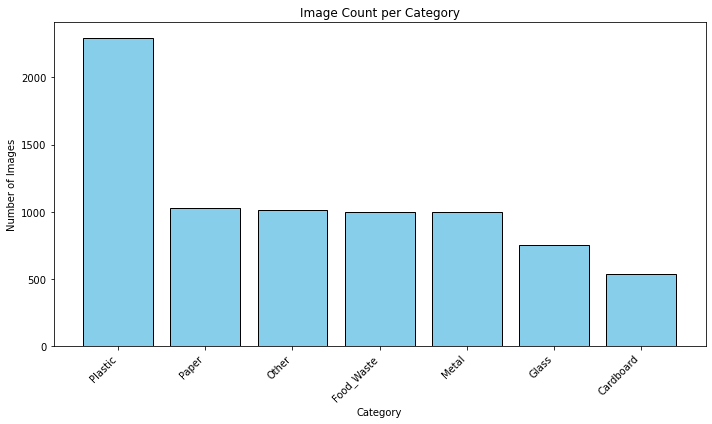

In [61]:
df = pd.DataFrame({'Category': lbls})
# Count howmany images in each category
counts = df['Category'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Image Count per Category')
plt.tight_layout()
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

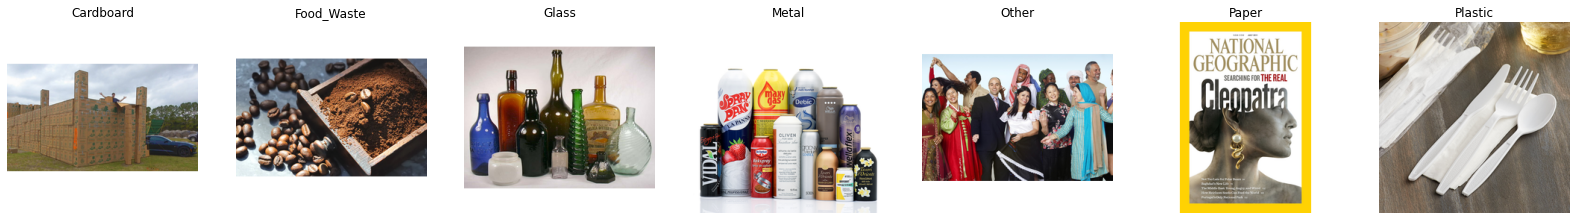

In [62]:

def show_one_per_category(imgs):
    """
    Display one image per category from a list of (category, filename, PIL.Image).
    """
    grouped = defaultdict(list)
    for cat, fname, img in imgs:
        grouped[cat].append(img)
    n = len(grouped)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    for ax, (cat, imgs_list) in zip(axes, grouped.items()):
        ax.imshow(imgs_list[0])
        ax.set_title(cat)
        ax.axis('off')
    plt.show()
    
show_one_per_category(imgs)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [63]:
# Find the smallest and largest image dimensions from the data set

heights = [img.shape[0] for img in img_arr]
widths  = [img.shape[1] for img in img_arr]

min_h, min_w = min(heights), min(widths)
max_h, max_w = max(heights), max(widths)

print(f"Min dimensions: {min_h} x {min_w}")
print(f"Max dimensions: {max_h} x {max_w}")


Min dimensions: 256 x 256
Max dimensions: 256 x 256


In [64]:
# Resize the image dimensions

target_size = (128,128)  # (width, height)

resized_arrays = []
for img in img_arr:
    pil = Image.fromarray(img)
    pil_resized = pil.resize(target_size)
    resized_arrays.append(np.array(pil_resized))

# resized_img_arr  = np.array([np.array(img) for img in resized_arrays]) / 255.0
resized_img_arr = np.stack(resized_arrays)
print("Resized shape:", resized_img_arr.shape)



Resized shape: (7625, 128, 128, 3)


In [66]:
# resized_img_arr

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [67]:
from sklearn.preprocessing import LabelEncoder

# Assume `labels` is a list or array of string labels
le = LabelEncoder()
y_int = le.fit_transform(lbls)  # Now your labels are integers from 0 to 6
y_int

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [68]:
# Assign specified parts of the dataset to train and validation sets

from sklearn.model_selection import train_test_split
import numpy as np

X = np.stack(resized_img_arr)  # your list of image arrays
y = y_int

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,         # 70% train, 30% validation
    stratify=y,            # preserves class distribution
    random_state=42
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Val shapes:", X_val.shape, y_val.shape)


Train shapes: (6100, 128, 128, 3) (6100,)
Val shapes: (1525, 128, 128, 3) (1525,)


In [69]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

In [74]:

# batch size, number of classes, epochs
batch_size = 50
num_classes = 7
epochs = 20

Test out different configurations and report the results in conclusions.

In [71]:
# Build and compile the model

model=Sequential()
#first conv layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

#second conv layer
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

#third conv layer
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# flatten and put a fully connected layer

model.add(Flatten())
model.add(Dense(512, activation='relu')) # fully connected
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 62, 62, 64)        256       
 chNormalization)                                                
                                                      

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [72]:
# Training

# usual cross entropy loss
# choose any optimiser such as adam, rmsprop etc
# metric is accuracy
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])


In [75]:
# fit the model
# this should take around 10-15 minutes when run locally on a windows/mac PC 
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/20
122/122 [==============================] - 151s 1s/step - loss: 3.1215 - accuracy: 0.1511 - val_loss: 2.0782 - val_accuracy: 0.1121
Epoch 2/20
122/122 [==============================] - 132s 1s/step - loss: 3.0675 - accuracy: 0.1523 - val_loss: 2.1531 - val_accuracy: 0.1318
Epoch 3/20
122/122 [==============================] - 137s 1s/step - loss: 3.0192 - accuracy: 0.1639 - val_loss: 2.1699 - val_accuracy: 0.1416
Epoch 4/20
122/122 [==============================] - 133s 1s/step - loss: 2.9662 - accuracy: 0.1661 - val_loss: 2.1618 - val_accuracy: 0.1469
Epoch 5/20
122/122 [==============================] - 137s 1s/step - loss: 2.9753 - accuracy: 0.1575 - val_loss: 2.1415 - val_accuracy: 0.1554
Epoch 6/20
122/122 [==============================] - 132s 1s/step - loss: 2.9389 - accuracy: 0.1689 - val_loss: 2.1337 - val_accuracy: 0.1672
Epoch 7/20
122/122 [==============================] - 137s 1s/step - loss: 2.9424 - accuracy: 0.1802 - val_loss: 2.1182 - val_accuracy: 0.1777

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [78]:
# Evaluate on the test set; display suitable metrics

# evaluate the model on test data
model.evaluate(X_val, y_val)

48/48 [==============================] - 6s 130ms/step - loss: 1.9529 - accuracy: 0.2348


[1.9528676271438599, 0.23475410044193268]

In [79]:
from sklearn.metrics import classification_report
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))


48/48 [==============================] - 6s 126ms/step
Classification Report:

              precision    recall  f1-score   support

   Cardboard       0.31      0.25      0.28       108
  Food_Waste       0.41      0.27      0.32       200
       Glass       0.15      0.48      0.23       150
       Metal       0.19      0.21      0.20       200
       Other       0.16      0.33      0.22       202
       Paper       0.28      0.14      0.18       206
     Plastic       0.61      0.15      0.24       459

    accuracy                           0.23      1525
   macro avg       0.30      0.26      0.24      1525
weighted avg       0.36      0.23      0.24      1525



<b>Analysis on Classification Report</b>

Precision and Recall are high only for Food_Waste, It's a classic case of a collapsed model or severe class imbalance handling failure and need data augmentation and more preprocessing.

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [20]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [21]:
# Create a function to augment the images




In [22]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [23]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

1. **Data-related Improvements**
   - Implement data augmentation to address class imbalance(e.g., Plastic has 3x more samples than Glass, approx 2.5x more samples than metal, paper etc.),
   - Collect more samples for underrepresented classes (especially Cardboard)
   - Include more diverse images within each category
   
   
2. **Model Enhancements**
   - Model accuracy is not that good(23%)
   - Experiment with deeper architectures or pre-trained models
   - Implement class weights to handle imbalanced data
   - Try different optimization strategies and hyperparameters
   
 
This demonstrates the potential of CNN-based approaches for waste segregation while highlighting areas for future improvement in both data collection and model architecture.
